## Convocatoria 1 - Proyecto 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2
import scipy

#### 0) Cargar una de las imágenes histológicas

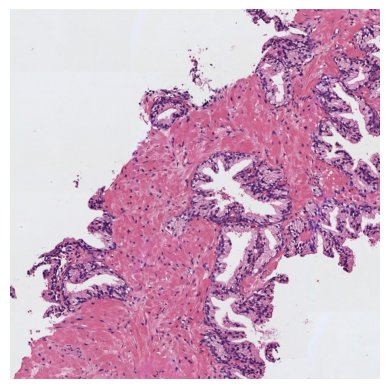

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
img = skimage.io.imread('histo_1.jpg')

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
img = skimage.util.img_as_float(img)

# Visualizar la imagen
plt.imshow(img)
plt.axis(False)
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

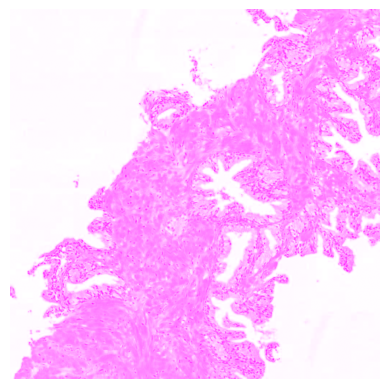

In [3]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Conversión a CMYK 
K = 1 - np.max(img, axis = 2)

with np.errstate(invalid = 'ignore', divide = 'ignore'):
    C = (1 - img[:, :, 0] - K) / (1 - K + 1e-10)
    M = (1 - img[:, :, 1] - K) / (1 - K + 1e-10)
    Y = (1 - img[:, :, 2] - K) / (1 - K + 1e-10)

# Imagen codificada en CMYK
cmyk = np.stack((C, M, Y, K), axis = 2)


# Visualizar la imagen del canal magenta
from matplotlib.colors import LinearSegmentedColormap

# Escala de colores solo con el canal magenta
plt.imshow(M, cmap = LinearSegmentedColormap.from_list("magenta", ["white", "magenta"]))
plt.imsave("magenta.png", M, cmap = LinearSegmentedColormap.from_list("magenta", ["white", "magenta"]))
plt.axis(False)
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

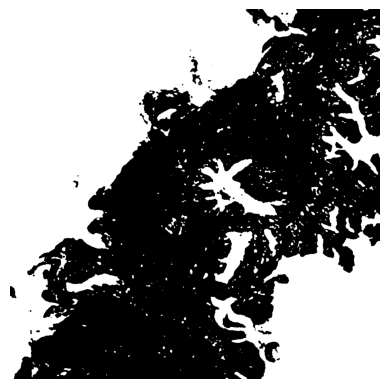

Threshold = 55


In [4]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

m_gauss = cv2.GaussianBlur(M, (5, 5), 0)
m_gauss = skimage.img_as_ubyte(m_gauss)
threshold, mask = cv2.threshold(m_gauss, 0, 1, cv2.THRESH_OTSU)
mask = ~ mask.astype(bool) # Binarizar e invertir la máscara

# Visualizar la máscara resultante
plt.imshow(mask, cmap = "gray")
plt.imsave("mask.png", mask, cmap = "gray")
plt.axis(False)
plt.show()

print(f"Threshold = {threshold:.0f}")

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

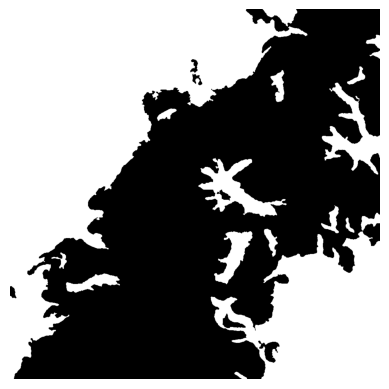

In [5]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

mask = skimage.morphology.remove_small_objects(mask, min_size = 300) # Artefactos negros
mask = ~ skimage.morphology.remove_small_objects(~ mask, min_size = 300) # Artefactos blancos

# Visualizar la máscara resultante
plt.imshow(mask, cmap = "gray")
plt.imsave("mask2.png", mask, cmap = "gray")
plt.axis(False)
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

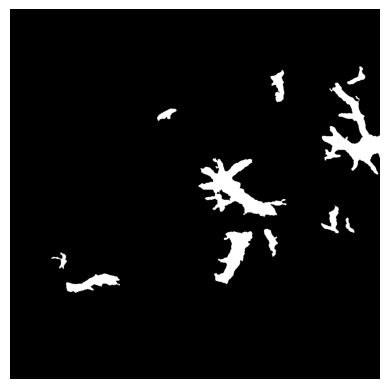

In [6]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

def remove_background(mask: np.ndarray, seeds_per_border: int = 50) -> np.ndarray:
    """
    Elimina el fondo de una máscara (regiones grandes de 1s) y lo reemplaza por 0s
    """
    h, w = mask.shape

    # Puntos de los bordes de la imagen
    borders = []
    x_linspace = np.linspace(0, w - 1, seeds_per_border, dtype = int)
    y_linspace = np.linspace(0, h - 1, seeds_per_border, dtype = int)

    borders += [(0, x)      for x in x_linspace] # lado superior
    borders += [(h - 1, x)  for x in x_linspace] # lado inferior
    borders += [(y, 0)      for y in y_linspace] # lado derecho
    borders += [(y, w - 1)  for y in y_linspace] # lado izquierdo
    
    # Eliminar repetidos
    borders = list(set(borders))
    borders.sort()
    
    # Aplicar 'region growing' en cada semilla
    background_mask = np.zeros_like(mask, dtype = np.uint8)

    for seed in borders:
        mask_copy = mask.copy().astype(np.uint8)
        background = np.zeros((h + 2, w + 2), dtype = np.uint8)
        cv2.floodFill(mask_copy, background, seed, 1)

        # Si el fondo detectado está entre un 1 y un 5% de la imagen,
        #   se ignora (es un lumen y no fondo)
        if background.sum() > 0.01 * h * w and \
            background.sum() < 0.05 * h * w:
            continue
        
        # Actualizar el fondo
        background_mask = background_mask | background[1:-1, 1:-1]
    
    return mask & ~ background_mask


lumen_mask = remove_background(mask)

# Visualizar la máscara resultante.
plt.imshow(lumen_mask, cmap = "gray")
plt.imsave("lumen_mask.png", lumen_mask, cmap = "gray")
plt.axis(False)
plt.show()

#### 5) Rellenar los objetos de los lúmenes

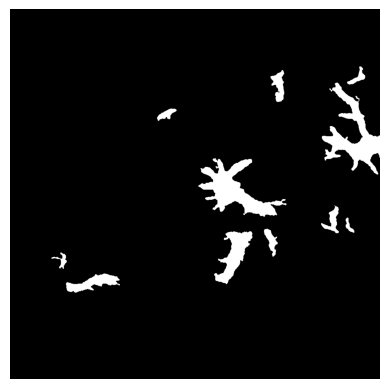

In [7]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
lumen_mask = scipy.ndimage.binary_fill_holes(lumen_mask)

# Visualizar la máscara resultante
plt.imshow(lumen_mask, cmap = "gray")
plt.imsave("lumen_mask2.png", lumen_mask, cmap = "gray")
plt.axis(False)
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

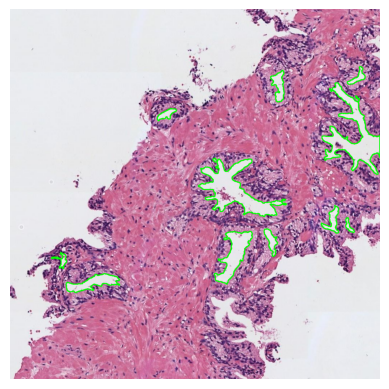

In [8]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 

lumen_contours, _ = cv2.findContours(lumen_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_with_lumen_contours = skimage.img_as_ubyte(img.copy())
cv2.drawContours(img_with_lumen_contours, lumen_contours, -1, color = (0,255,0), thickness = 2)


# Visualizar la imagen superpuesta
plt.imshow(img_with_lumen_contours)
plt.imsave("img_with_lumen_contours.png", img_with_lumen_contours)
plt.axis(False)
plt.show()

#### 7) Identificar y cropear el lumen más grande

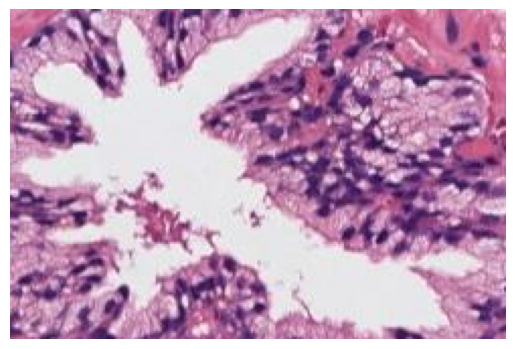

In [9]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.

labeled_lumen_mask = skimage.measure.label(lumen_mask)
lumen_props = skimage.measure.regionprops(labeled_lumen_mask)


largest_lumen = max(lumen_props, key = lambda l: l.area)
min_x, min_y, max_x, max_y = largest_lumen.bbox # Coordenadas de la bounding box


# Visualizar el lumen cropeado.
plt.imshow(img[min_x:max_x, min_y:max_y])
plt.imsave("largest_lumen.png", img[min_x:max_x, min_y:max_y])
plt.axis(False)
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [10]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

features = {
    "Área": "area",
    "Área de la bounding box": "bbox_area",
    "Área convexa": "convex_area",
    "Exentricidad": "eccentricity",
    "Diámetro equivalente": "equivalent_diameter",
    "Extensión": "extent",
    "Diámetro Feret": "feret_diameter",
    "Longitud del eje mayor": "major_axis_length",
    "Longitud del eje menor": "minor_axis_length",
    "Orientación": "orientation",
    "Perímetro": "perimeter",
    "Solidez": "solidity",
    "Compacidad": "compactness"
}

# Mayor distancia entre dos puntos cualesquiera
largest_lumen.feret_diameter = scipy.spatial.distance.pdist(largest_lumen.coords).max()
# Ratio de circularidad
largest_lumen.compactness = 4 * np.pi * largest_lumen.area / largest_lumen.perimeter ** 2

for index, (feature_name, feature_value) in enumerate(features.items()):
    value = largest_lumen[feature_value] if feature_value is not None else np.nan
    print(f"{index + 1:>2}) {feature_name:<23} : {value:>12,.4f}")

 1) Área                    :  14,061.0000
 2) Área de la bounding box :  39,935.0000
 3) Área convexa            :  29,181.0000
 4) Exentricidad            :       0.8470
 5) Diámetro equivalente    :     133.8022
 6) Extensión               :       0.3521
 7) Diámetro Feret          :     257.7693
 8) Longitud del eje mayor  :     238.1596
 9) Longitud del eje menor  :     126.5861
10) Orientación             :       1.0044
11) Perímetro               :   1,235.9758
12) Solidez                 :       0.4819
13) Compacidad              :       0.1157
